In [1]:
import json
import os
import pickle
import psycopg2
import sqlalchemy
import pyproj
import sys
sys.path.append("..")

import geopandas as gpd
from geopandas.geoseries import GeoSeries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib.animation as animation
from shapely.geometry import Point
from datetime import datetime
from dateutil.relativedelta import relativedelta
import imageio
from IPython.display import Image
get_ipython().magic(u'matplotlib inline')
%matplotlib inline

from connect_db import db_connection

# filter annyoing warning from pandas
import warnings
warnings.filterwarnings('ignore')

In [2]:
username='bdelpapa'

In [3]:
cred_location = '/mnt/data/'+username+'/TPT_tourism/connect_db/data_creds_redshift.json.nogit'
db = db_connection.DBConnection(cred_location)

In [4]:
# Load maps data 

# load data from TPT (use this from now on)
regions = r"/mnt/data/shared/Boundaries regions and municipalities Italy 2016/Reg2016_WGS84_g/Reg_2016_WGS84_g.shp"
provinces = r"/mnt/data/shared/Boundaries regions and municipalities Italy 2016/CMProv2016_WGS84_g/CMprov2016_WGS84_g.shp"
territories =  r"/mnt/data/shared/Tus_28districts.shp"
municipalities = r"/mnt/data/shared/Boundaries regions and municipalities Italy 2016/Com2016_WGS84_g/Com2016_WGS84_g.shp"

# important cities 
important_cities_tuscany = r"/mnt/data/shared/important_cities.csv"

In [5]:
# Load files and select only Tuscany
# reg, pro, mun are for the whole italy
# ter is only for tuscany, and already in lat,lon coords

gdf_reg = gpd.read_file(regions)
gdf_pro = gpd.read_file(provinces)
gdf_ter = gpd.read_file(territories)
gdf_mun = gpd.read_file(municipalities)

# Convert coordinates in WGS84 to Lat Lon format 
# see http://geopandas.org/projections.html
gdf_reg['geometry'] = gdf_reg['geometry'].to_crs(epsg=4326)
gdf_pro['geometry'] = gdf_pro['geometry'].to_crs(epsg=4326)
gdf_mun['geometry'] = gdf_mun['geometry'].to_crs(epsg=4326)

# important cities 
important_cities_tuscany = r"/mnt/data/shared/important_cities.csv"
df_impcit = pd.read_csv(important_cities_tuscany)

# 9 is for Tuscany only
gdf_reg_tus = gdf_reg[gdf_reg["COD_REG"] == 9] 
gdf_pro_tus = gdf_pro[gdf_pro["COD_REG"] == 9]
gdf_ter_tus = gdf_ter # this one is already Tuscany only
gdf_mun_tus = gdf_mun[gdf_mun["COD_REG"] == 9]

In [6]:
# Helper functions for plotting the heatmaps

def heatmap_plot(gdf_map, ax, clog=False, header='count', colorbar=True, title=False):
    """
    Plot the Point counts heatmap per municipality
    
    Params:
        gdf_map: GeoDataFrame with the 'header' field - it should NOT contain zeros
        axis: Axis object with the figure elements
        header: str with the name of the field to be ploted
        colorbar: bool, include or not a colorbar in the plot
    """
    
    # create the new log column
    header_log = 'log_'+header
    gdf_map[header_log] = np.log(gdf_map[header])
    
    # cash some useful values
    if clog is False:
        clog_min = np.round(gdf_map[header_log].min(), 6)
        clog_max = np.round(gdf_map[header_log].max(), 6)
    else:
        clog_min = np.round(clog[0], 6)
        clog_max = np.round(clog[1], 6)
    clog_range = np.linspace(clog_min, clog_max, num=5)
    
    # plot
    gdf_map.plot(column=header_log, ax=ax, 
                 vmin=clog_min, vmax=clog_max,
                 cmap='Reds',
                 edgecolor='gray',
                 alpha=0.6)
    
    if title is not False:
        ax.set_title(title, fontsize=15)
    
    if colorbar:
    
        norm = Normalize(vmin=clog_min, vmax=clog_max)
        n_cmap = cm.ScalarMappable(norm=norm, cmap='Reds')
        n_cmap.set_array([])
        
        cbar = ax.get_figure().colorbar(n_cmap, fraction=0.03, ticks=clog_range)
        
        cbar.ax.set_yticks(clog_range)
        cbar.ax.set_yticklabels(np.exp(clog_range).astype(int))
        cbar.ax.set_ylabel('# unique visitors', rotation=270, labelpad=25, fontsize=15) 
    
        
# there are 6 municipalities with 0 towers or visits:
# Capolona, Molazzana, Sassetta, Casale Maritimo, Filattiera, Tresana
def heatmap_replace_zeros(gdf_map, header='count'):
    """
    Replace zeros with the minimum positive count
    
    Params:
        gdf_map: GeoDataFrame with the 'header' field
        header: field in which zeros are replaced by the minimum value
    """    
    
    min_Point_count = np.array(gdf_map[header])
    gdf_map.loc[gdf_map[header]==0, header] = np.min(min_Point_count[np.nonzero(min_Point_count)])


def important_cities(df_impcit):
    """
    Include important cities in the plot
    
    Params:
        df_impcit: DataFrame with the 'lat', 'long', and 'city' fields
    """

    for i, name in enumerate(list(df_impcit.city)):
        plt.plot(df_impcit.long[i], df_impcit.lat[i], 'o', color='k', markersize=6)
        plt.annotate(name, (df_impcit.long[i]+0.03, df_impcit.lat[i]),
                     fontsize=15)

In [9]:
# functions to run queries

def query_count_territory(gdf_ter_map,
                          min_date = '2017-05-01 00:00:00', 
                          max_date = '2018-02-28 23:59:59'):
    '''
    Run the query for unique customers in each territory in a given time window
    
    Params:
        gdf_ter_map: GeoDataFrame with the field 'rown', loaded from /mnt/data/shared
        min_date: minimum date, in the yyy-mm-dd hh:mm:ss format
        max_date: maximum date, in the same format
        
    Returns:
        gdf_merged_map: GeoDataFrame with the unique counts for each territory
    '''

    query="""
    select count(distinct customer_id), location_dictionary.territory
    from tuscany.vodafone
    join tuscany.location_dictionary on location_dictionary.location_id = vodafone.location_id
    where time_stamp between '"""+min_date+"""' and '"""+max_date+"""'
    and territory is NOT NULL
    group by tuscany.location_dictionary.territory;
    """
    df_count_territory = db.sql_query_to_data_frame(query, cust_id=True)
    
    gdf_merged_map = gdf_ter_map.merge(df_count_territory, how = 'inner', left_on='rown', right_on='territory')
    
    return gdf_merged_map

In [10]:
# query for the whole year
# TODO: this query should be dumped in a table at /mnt/data/shared 
# to avoid running it again every morning

gdf_full = query_count_territory(gdf_ter_tus)

InterfaceError: (psycopg2.InterfaceError) connection already closed (Background on this error at: http://sqlalche.me/e/rvf5)

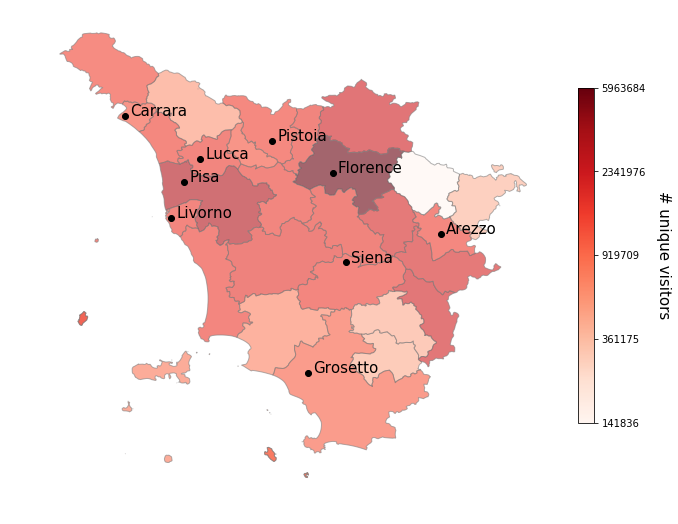

In [63]:
# plot heatmap for the whole year

fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(1, 1, 1)

heatmap_replace_zeros(gdf_full) # just to avoid any problems with -inf
heatmap_plot(gdf_full, ax)
important_cities(df_impcit)

plt.axis('off')
plt.savefig(r"/mnt/data/shared/heatmaps/May-Feb.pdf")

In [12]:
# queries for each month (takes around 2 min)

# create months datetime list
# minimum date is '2017-05-01 00:00:00'
# maximun date is '2017-28-02 23:59:59'
start_dt = datetime(2017, 4, 30, hour=23, minute=59, second=59)
end_dt = datetime(2018, 2, 28, hour=23, minute=59, second=59)
months_dt = []
for i in pd.date_range(start=start_dt, end=end_dt, freq='1M'):
    months_dt.append(str(i + relativedelta(hour=23, minute=59, second=59)))
    
# create dictionary with heatmaps for every month
heatmaps_per_month = {}
for i in range(len(months_dt)-1):
    
    month_start = months_dt[i]
    month_end = months_dt[i+1]
    
    gdf_month = query_count_territory(gdf_ter_tus, min_date = month_start, max_date = month_end)
    cur_month = datetime.strptime(months_dt[i+1], "%Y-%m-%d %H:%M:%S").strftime("%B")
    
    heatmaps_per_month[cur_month] = gdf_month  

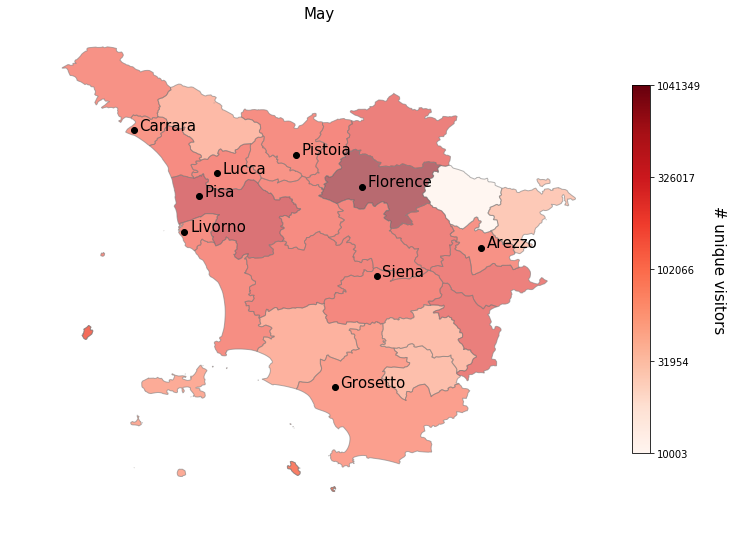

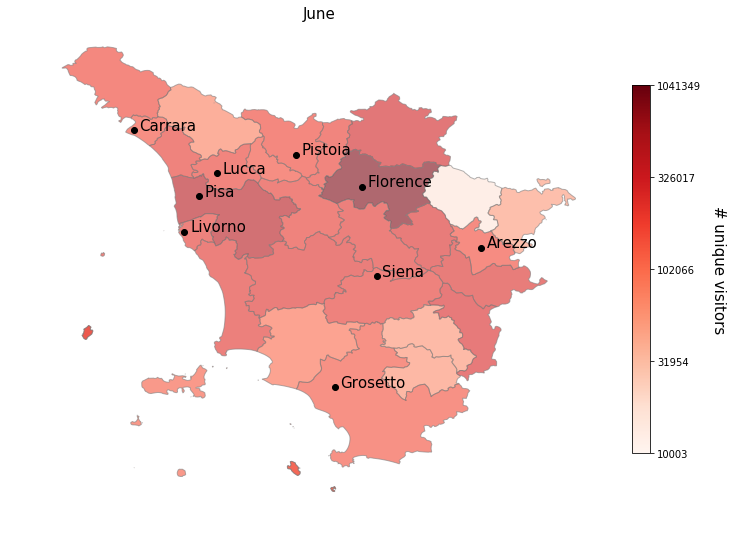

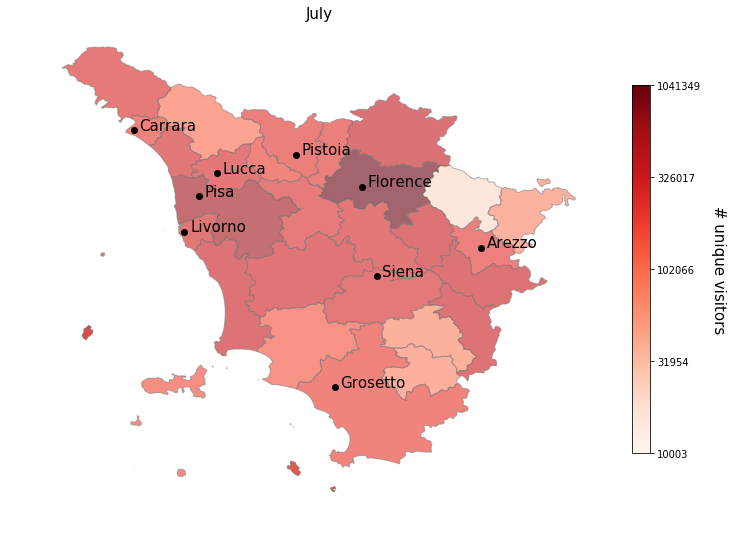

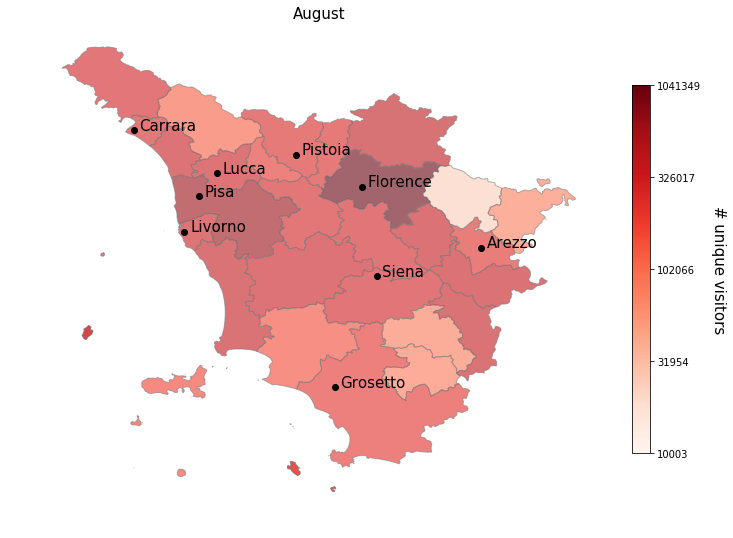

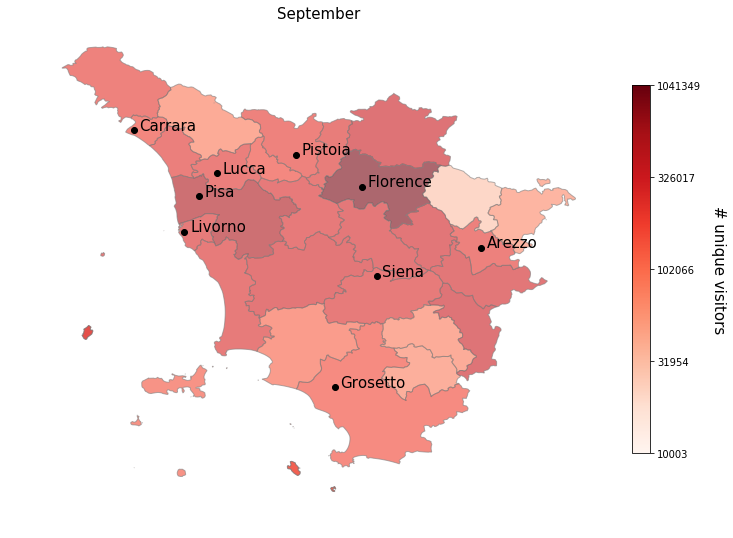

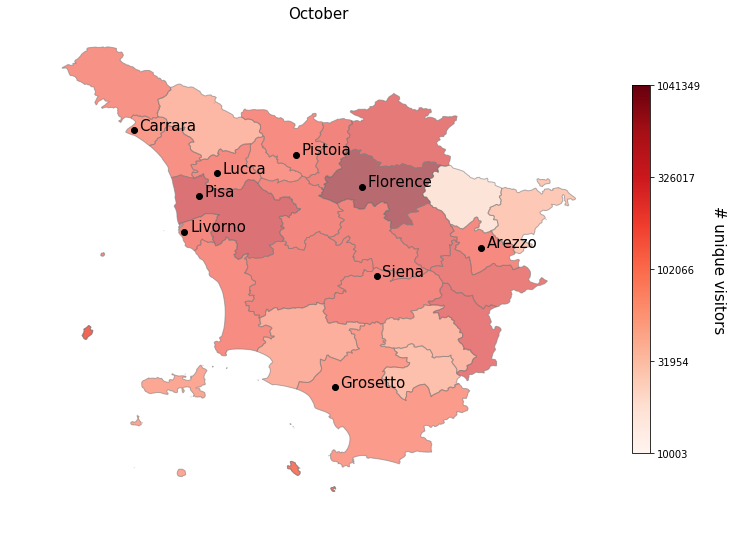

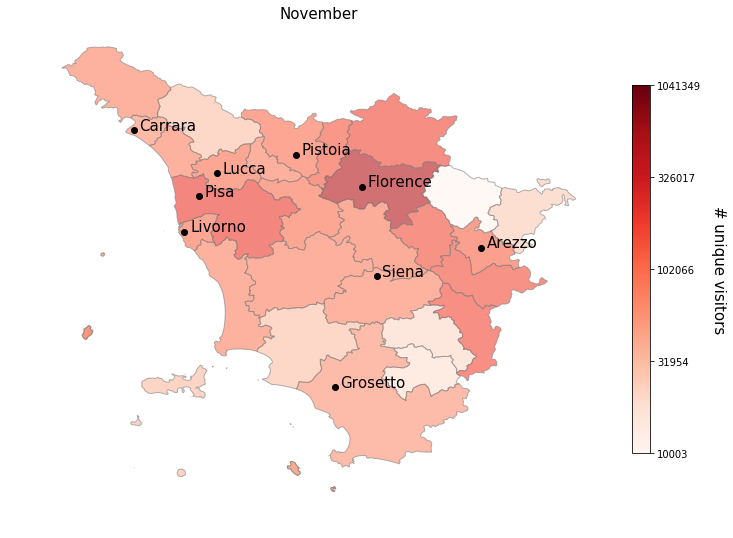

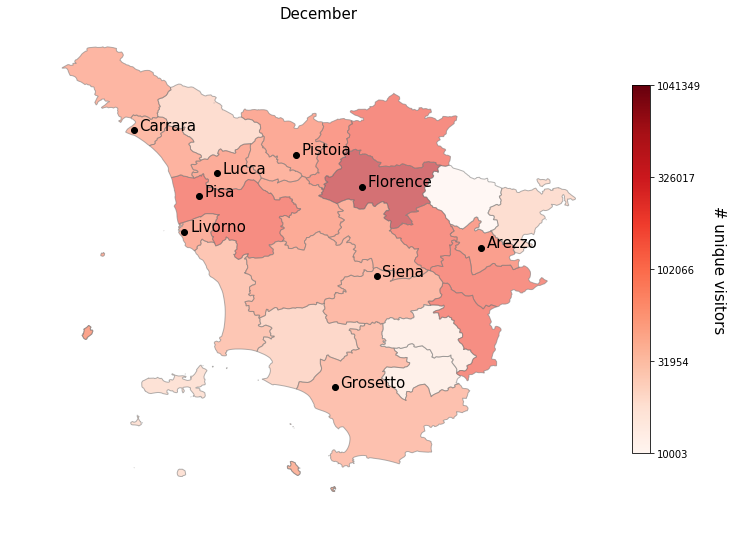

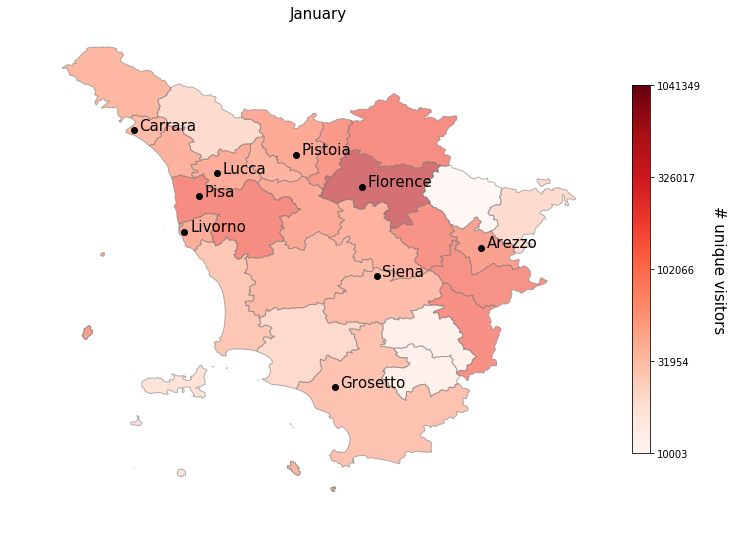

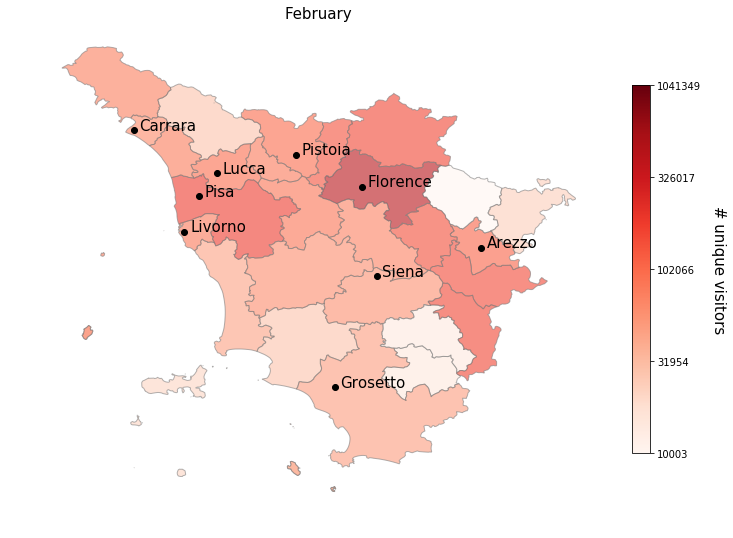

In [64]:
# heatmap plots for each month

# find overall minimum and maximum
min_count_month = []
max_count_month = []
for month, gdf_month in heatmaps_per_month.items():   
    min_count_month.append(gdf_month['count'].min())
    max_count_month.append(gdf_month['count'].max())
min_count = np.array(min_count_month).min()
min_logcount = np.log(min_count)
max_count = np.array(max_count_month).max()
max_logcount = np.log(max_count)

# create monthly heatmaps
for month, gdf_month in heatmaps_per_month.items():
    
    fig = plt.figure(figsize=(11, 9))
    ax = fig.add_subplot(1, 1, 1)    
    
    heatmap_replace_zeros(gdf_month)
    heatmap_plot(gdf_month, ax, clog=[min_logcount, max_logcount], title=month)  
    important_cities(df_impcit)
    
    plt.axis('off')
    plt.savefig(r"/mnt/data/shared/heatmaps/monthly/"+month+".png")

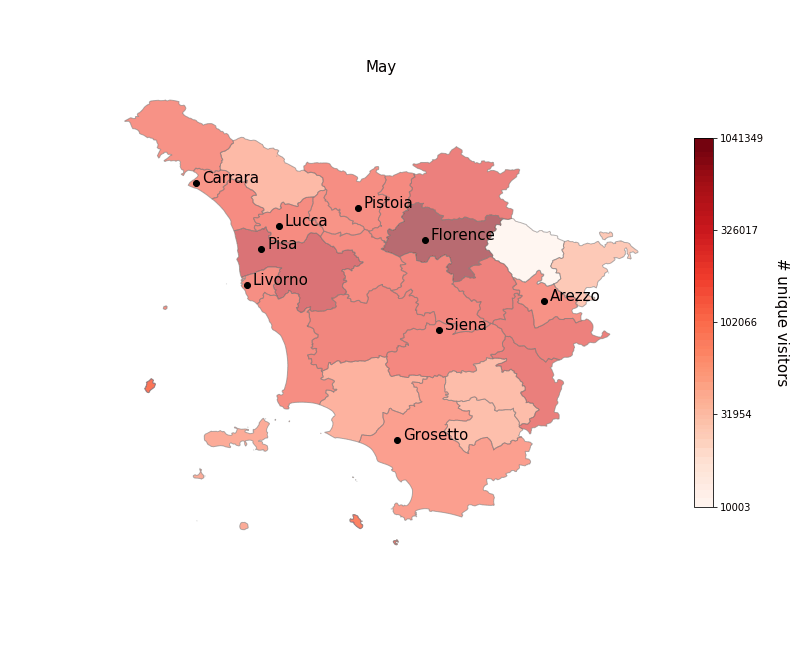

In [67]:
# creat gif with monthly heatmaps

filenames = []
for month in heatmaps_per_month.keys():
    filenames.append("/mnt/data/shared/heatmaps/monthly/"+month+".png")

images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('/mnt/data/shared/heatmaps/monthly/movie.gif', images, duration=1)

Image(filename="/mnt/data/shared/heatmaps/monthly/movie.gif")

In [68]:
# load route files

# load sample random routes
sample_routes_file = r"/mnt/data/shared/customer_ids_for_data_stories.csv"
sample_routes_one_day_file = r"/mnt/data/shared/customer_ids_for_data_stories_one_day_tripeers.csv"
df_sample_routes = pd.read_csv(sample_routes_file)
df_sample_routes_oneday = pd.read_csv(sample_routes_one_day_file) 
df_routes = pd.concat([df_sample_routes_oneday, df_sample_routes]) # concat in one
df_routes.index = range(0, len(df_routes))                         # change index

In [71]:
# run queries for trajectories, for each of the 80 sample random routes

queries = []
df_single_customers = []
for i in range(80):
    customer_id = df_routes.loc[i, 'customer_id']
    
    # query to retrieve lat lon based on custumer id
    query = """
   
    select tpt.tuscany.location.lat,  tpt.tuscany.location.lon
    from tpt.tuscany.vodafone
    inner join tpt.tuscany.location on tpt.tuscany.vodafone.cur_loc = tpt.tuscany.location.location_id
    where customer_id = '"""+str(customer_id)+"""'
    order by tpt.tuscany.vodafone.cur_time_stamp
    """
    queries.append(query)
    df_single_customer = db.sql_query_to_data_frame(query)    
    df_single_customers.append(df_single_customer)

ProgrammingError: (psycopg2.ProgrammingError) column vodafone.cur_loc does not exist
 [SQL: "\n   \n    select tpt.tuscany.location.lat,  tpt.tuscany.location.lon\n    from tpt.tuscany.vodafone\n    inner join tpt.tuscany.location on tpt.tuscany.vodafone.cur_loc = tpt.tuscany.location.location_id\n    where customer_id = 'C62F44C3532C9E895C859B19AAA802B0'\n    order by tpt.tuscany.vodafone.cur_time_stamp\n    "] (Background on this error at: http://sqlalche.me/e/f405)

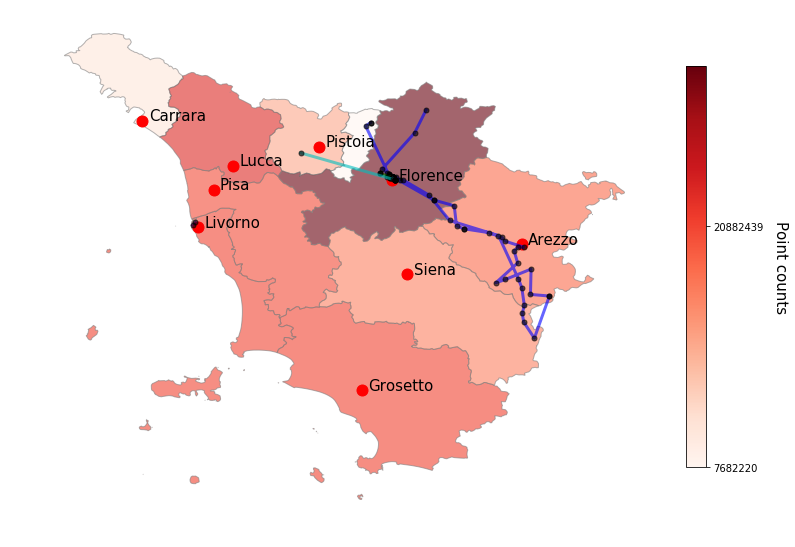

In [90]:
# Plot map with trajectories (example)
day_trips = [0, 24]
long_weekends = [24, 3*24]
vacation = [3*24, 7*24]

heatmap_plot(df_pro_tusc)
#df_tusc.plot(color='white', edgecolor='gray', figsize=(15, 15), alpha=1) # only borders

# plot important cities
for i, name in enumerate(list(important_cities.city)):
    plt.plot(important_cities.long[i], important_cities.lat[i], 'o', color='r', markersize=11)
    plt.annotate(name, (important_cities.long[i]+0.03, important_cities.lat[i]),
                 fontsize=15)        

from cycler import cycler
#plt.rc('axes', prop_cycle=(cycler('color', ['orange', 'g', 'b'])))
plt.rc('axes', prop_cycle=(cycler(color='bgcmyk')))
for i in reversed(range(80)):
    # plot
    if day_trips[0] < df_routes.loc[i, 'hours'] <= day_trips[1]:
        plt.plot(df_single_customers[i].lon, df_single_customers[i].lat, '-', linewidth=3, alpha=0.6)
        plt.plot(df_single_customers[i].lon, df_single_customers[i].lat, 'o', color='k', markersize=5, alpha=0.6)     
        
plt.axis('off')
plt.show()

In [91]:
# Query counts per time of the day and day of the week
# TODO: a for loop should take care of all this
query_w_am = """
with loc_density as (

select cur_loc,count(distinct(customer_id)) 
from tpt.tuscany_test.vodafone_trunc
where extract(hour from tpt.tuscany_test.vodafone_trunc.cur_time_stamp) < 12 and
extract(dow from tpt.tuscany_test.vodafone_trunc.cur_time_stamp) < 6 and 
extract(dow from tpt.tuscany_test.vodafone_trunc.cur_time_stamp) > 0 
group by cur_loc

)

select tpt.tuscany_test.location.lon ,tpt.tuscany_test.location.lat ,loc_density.count from loc_density
inner join tpt.tuscany_test.location on cur_loc = location_id
order by count desc;
"""
df_vodafone_w_am = db.sql_query_to_data_frame(query_w_am)

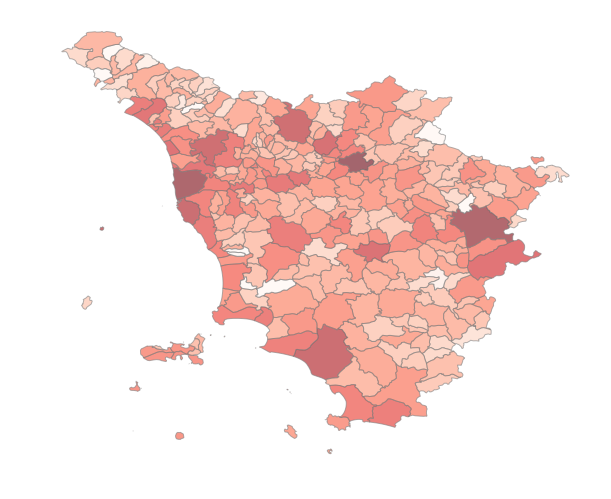

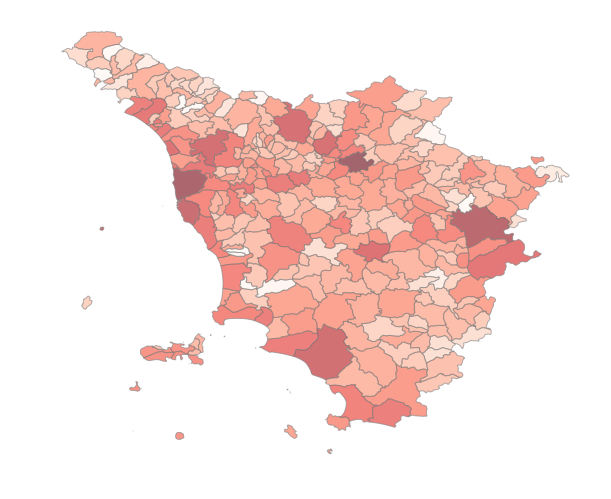

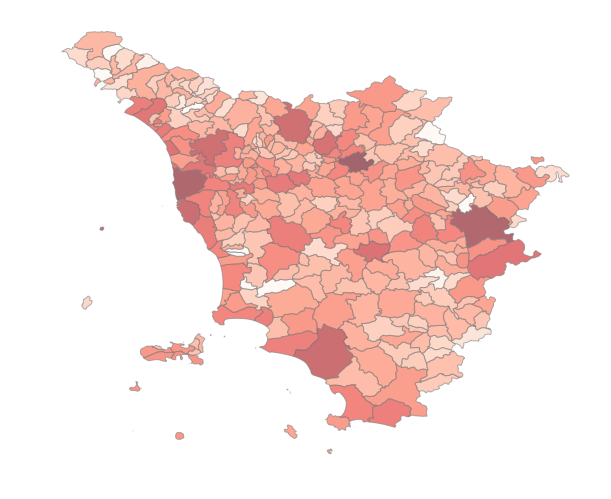

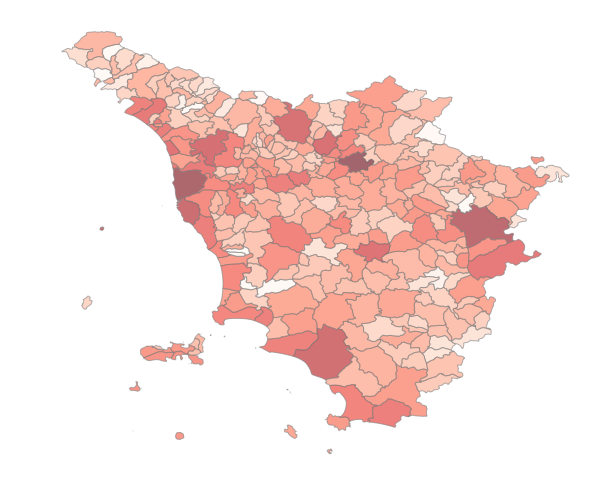

In [225]:
# heatmap subplots am/pm
# TODO: this should be plotted in a grid for better visualization

# replace zeros for minimum positive value
for header in ['Points_w_am', 'Points_we_am', 'Points_w_pm', 'Points_we_pm']:
    min_Point_count = np.array(df_mun_tusc[header])
    df_mun_tusc.loc[df_mun_tusc[header]==0, header] = np.min(min_Point_count[np.nonzero(min_Point_count)])

    
#fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(15, 15))
heatmap_plot(df_mun_tusc, header='Points_w_am', colorbar=False)
plt.axis('off')
heatmap_plot(df_mun_tusc, header='Points_we_am', colorbar=False)
plt.axis('off')
heatmap_plot(df_mun_tusc, header='Points_w_pm', colorbar=False)
plt.axis('off')
heatmap_plot(df_mun_tusc, header='Points_we_pm', colorbar=False)
plt.axis('off')

plt.show()

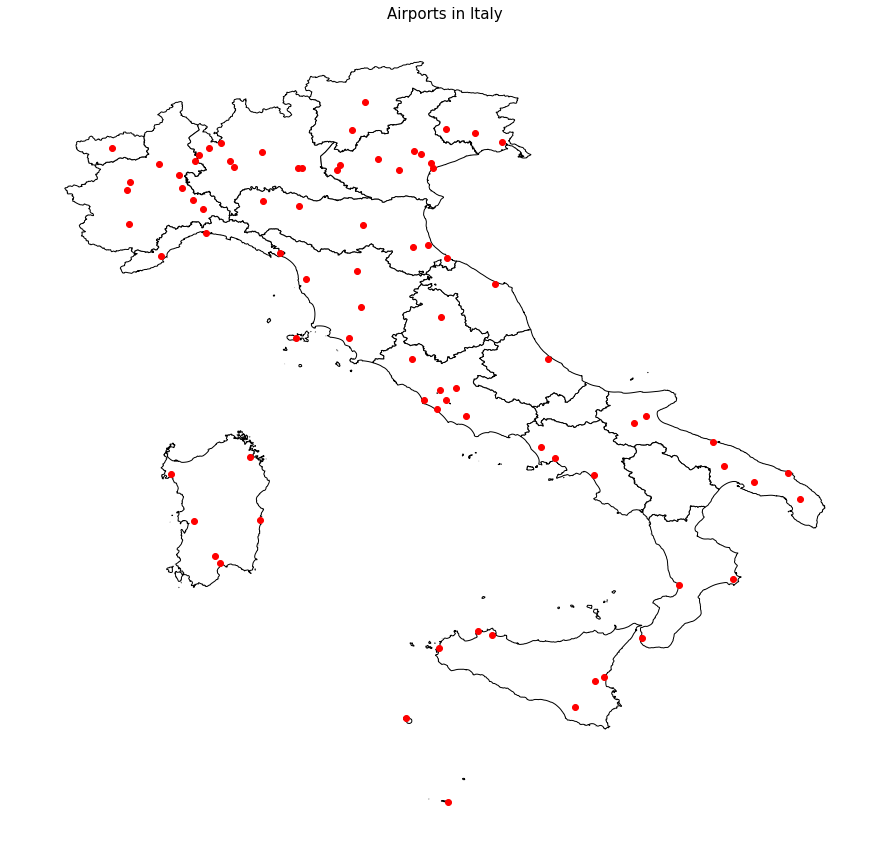

In [117]:
# Airports in Italy

airports = r"/mnt/data/shared/airports.dat"
air_df = pd.read_csv(airports, names = ["Airport ID", 
                                        "Name", 
                                        "City", 
                                        "Country",
                                        "IATA",
                                        "ICAO",
                                        "Lat",
                                        "Lon",
                                        "Alt",
                                        "Timezone",
                                        "DST",
                                        "Tz",
                                        "Type",
                                        "Source"])
air_df = air_df[air_df['Country']=='Italy']

# Plot airports in Italy
df_italy = gpd.read_file(regions)
#df_italy = df_italy[df_italy["COD_REG"] == 9]   # 9 = tuscany
df_italy['geometry'] = df_italy['geometry'].to_crs(epsg=4326)

lats_air = air_df['Lat']
longs_air = air_df['Lon']
locs_air = [Point(xy) for xy in zip(lats_air, longs_air)]

df_italy.plot(color='white', edgecolor='k', figsize=(15, 15), alpha=1) # only borders
plt.plot(longs_air, lats_air, 'o', color='r')
plt.title('Airports in Italy', fontsize=15)

plt.axis('off')
plt.show()

In [72]:
## load roads and rails in tuscany

# rails and roads
rails_file = r"/mnt/data/shared/ITA_shapefiles/ITA_rails.shp"
roads_file = r"/mnt/data/shared/ITA_shapefiles/ITA_roads.shp"

gdf_roads = gpd.read_file(roads_file)
gdf_rails = gpd.read_file(rails_file)

In [73]:
# rails and roads in tuscany

tus_roads = gdf_roads[gdf_roads.intersects(gdf_reg_tus['geometry'][8])]
tus_rails = gdf_rails[gdf_rails.intersects(gdf_reg_tus['geometry'][8])]

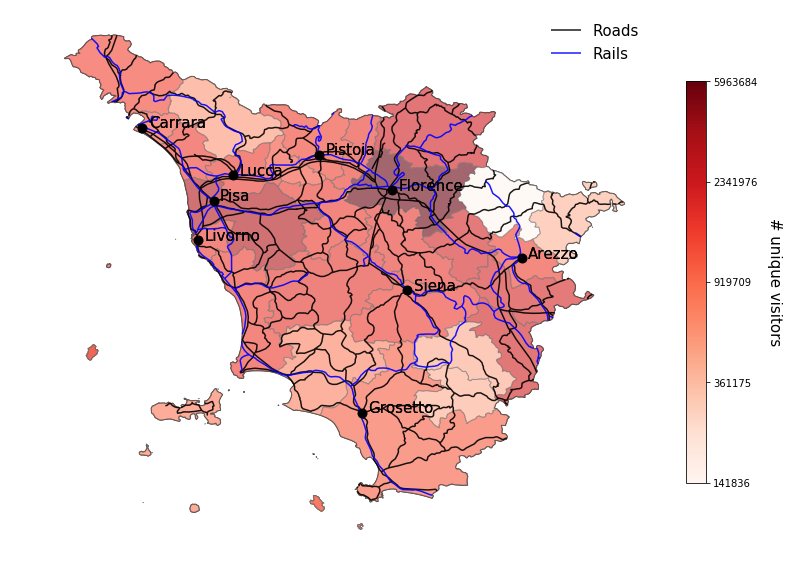

In [75]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1,1,1)

gdf_reg_tus.plot(ax=ax,color='w', edgecolor='k')

tus_roads.intersection(gdf_reg_tus['geometry'].unary_union).plot(ax=ax, color='k', alpha=0.9, label='Roads')
tus_rails.intersection(gdf_reg_tus['geometry'].unary_union).plot(ax=ax, color='b', alpha=0.9, label='Rails')
#tus_rails.plot(ax=ax, color='b', alpha=0.5, label='Rails')

# plot important cities
for i, name in enumerate(list(df_impcit.city)):
    plt.plot(df_impcit.long[i], df_impcit.lat[i], 'o', color='k', markersize=9)
    plt.annotate(name, (df_impcit.long[i]+0.03, df_impcit.lat[i]),
                 fontsize=15) 

heatmap_replace_zeros(gdf_full) # just to avoid any problems with -inf
heatmap_plot(gdf_full, ax)
important_cities(df_impcit)

plt.axis('off')
plt.legend(loc='best', fontsize=15, frameon=False)
plt.savefig(r"/mnt/data/shared/heatmaps/rails.png")
plt.show()